In [1]:
import pyemma
pyemma.__version__

/home/farzin/mambaforge/envs/Pyemma/lib/python3.6/site-packages/pyemma/util/log.py:65: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)


'2.5.2'

/home/farzin/mambaforge/envs/Pyemma/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.2.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma import config

In [4]:

import matplotlib.pyplot as plt

def save_figure_H(name, width=10, height=8, dpi=300, label_size=12, tick_size=12):
    """
    Saves the current figure with specified dimensions, DPI, and ensures
    x and y labels and ticks are of at least a specific font size.
    
    Parameters:
        name (str): The name of the file to save.
        width (float): The width of the figure in inches. Default is 10.
        height (float): The height of the figure in inches. Default is 8.
        dpi (int): The resolution in dots per inch. Default is 300.
        label_size (int): Font size for x and y labels. Default is 12.
        tick_size (int): Font size for x and y ticks. Default is 12.
    """
    do_save = True
    fig_dir = './'
    if do_save:
        # Update figure size
        plt.gcf().set_size_inches(width, height)
        
        # Update x and y label font sizes
        ax = plt.gca()
        ax.xaxis.label.set_size(label_size)
        ax.yaxis.label.set_size(label_size)
        
        # Update tick font sizes
        ax.tick_params(axis='x', labelsize=tick_size)
        ax.tick_params(axis='y', labelsize=tick_size)
        
        # Save the figure
        plt.savefig(fig_dir + name, bbox_inches='tight', dpi=dpi)



##  load data

We first define the pdb file and the xtc trajectories used as input files

In [5]:
indir = '/home/farzin/Projects/Hydro-Binding/MSM/NewHyd-WT-100H2/1-Bottleneck'
topfile =  indir+'/concatenated-H2-Mdg-SampleFrame.pdb'
traj_list = ['/home/farzin/Projects/Hydro-Binding/MSM/NewHyd-WT-100H2/1-Bottleneck/concatenated-H2-Mdg.xtc']


In [6]:
import pyemma

feat = pyemma.coordinates.featurizer(topfile)

# Define residue numbers
residues = [322, 370]

# Select non-hydrogen atoms explicitly by excluding known hydrogen names
atoms_331 = feat.select(f"resid {residues[0] - 1} and not name H and not name HA and not name HB and not name HG11 and not name HG12 and not name HG13 and not name HG21 and not name HG22 and not name HG23")
atoms_379 = feat.select(f"resid {residues[1] - 1} and not name H and not name HA and not name HG and not name HB1 and not name HB2 and not name HB3 and not name HD11 and not name HD12 and not name HD13 and not name HD21 and not name HD22 and not name HD23 and not name HD11 and not name HD11")

# Ensure valid atom selections
if len(atoms_331) == 0 or len(atoms_379) == 0:
    raise ValueError("Non-hydrogen atom selection for one of the residues is empty. Check the topology file.")

# Collect all pairwise distances between non-hydrogen atoms of residue 331 and residue 379
atom_pairs = [[atom1, atom2] for atom1 in atoms_331 for atom2 in atoms_379]

# Add all atom-pair distances as features
feat.add_distances(atom_pairs)

print(f"Feature setup completed with {len(atom_pairs)} pairwise distances between non-hydrogen atoms of residues 331 and 379.")


Feature setup completed with 56 pairwise distances between non-hydrogen atoms of residues 331 and 379.


In [7]:
feat.describe()[:1000]

['DIST: VAL 325 N 4834 - LEU 373 N 5580',
 'DIST: VAL 325 N 4834 - LEU 373 CA 5582',
 'DIST: VAL 325 N 4834 - LEU 373 CB 5584',
 'DIST: VAL 325 N 4834 - LEU 373 CG 5587',
 'DIST: VAL 325 N 4834 - LEU 373 CD1 5589',
 'DIST: VAL 325 N 4834 - LEU 373 CD2 5593',
 'DIST: VAL 325 N 4834 - LEU 373 C 5597',
 'DIST: VAL 325 N 4834 - LEU 373 O 5598',
 'DIST: VAL 325 CA 4836 - LEU 373 N 5580',
 'DIST: VAL 325 CA 4836 - LEU 373 CA 5582',
 'DIST: VAL 325 CA 4836 - LEU 373 CB 5584',
 'DIST: VAL 325 CA 4836 - LEU 373 CG 5587',
 'DIST: VAL 325 CA 4836 - LEU 373 CD1 5589',
 'DIST: VAL 325 CA 4836 - LEU 373 CD2 5593',
 'DIST: VAL 325 CA 4836 - LEU 373 C 5597',
 'DIST: VAL 325 CA 4836 - LEU 373 O 5598',
 'DIST: VAL 325 CB 4838 - LEU 373 N 5580',
 'DIST: VAL 325 CB 4838 - LEU 373 CA 5582',
 'DIST: VAL 325 CB 4838 - LEU 373 CB 5584',
 'DIST: VAL 325 CB 4838 - LEU 373 CG 5587',
 'DIST: VAL 325 CB 4838 - LEU 373 CD1 5589',
 'DIST: VAL 325 CB 4838 - LEU 373 CD2 5593',
 'DIST: VAL 325 CB 4838 - LEU 373 C 5597'

In [8]:
inp = coor.source(traj_list, feat)
X = inp.get_output(chunk=1000)
print('Number of trajectories = ', len(X))
print('Trajectory length = ', X[0].shape[0])
print('Total data = ', len(X) * X[0].shape[0], 'frames')
print('Number of dimensions = ', X[0].shape[1])

# Check the distances for the first few frames
print("Distances (first few frames):", X[0][:10])


100%|██████████| 1894/1894 [21:36<00:00,  1.68it/s]                                 

Number of trajectories =  1
Trajectory length =  1893557
Total data =  1893557 frames
Number of dimensions =  56
Distances (first few frames): [[ 1.3549633   1.33728492  1.19676948  1.080145    0.9443689   1.07976186
   1.44563985  1.49448347  1.23134267  1.2200526   1.07978439  0.96395046
   0.8274067   0.97704911  1.32770026  1.38342702  1.12243378  1.09890807
   0.95524389  0.84517282  0.70396042  0.85691738  1.20200777  1.2514267
   1.0001055   0.98312491  0.83918566  0.7336272   0.59036434  0.76713842
   1.08286214  1.14068341  1.0819304   1.05529356  0.91778129  0.79875964
   0.66857326  0.78466374  1.16750348  1.21055126  1.27900481  1.27317047
   1.13140666  1.02416861  0.88433969  1.05784976  1.37270343  1.43490529
   1.25768697  1.26507163  1.12853992  1.01980615  0.88667905  1.06297469
   1.36654818  1.43739355]
 [ 1.34326839  1.3181783   1.17223942  1.05500221  0.92056286  1.05912459
   1.43753445  1.47227526  1.22204947  1.20235813  1.05391836  0.94168591
   0.80100238  0.

In [9]:
tica_lag = 100 # tica lagtime, 1 ns (XTC every 10 ps)
#tica_obj = coor.tica(X, lag=tica_lag)
tica_obj = coor.tica(X, lag=tica_lag)

Y = tica_obj.get_output()[0]
print('Projected data shape = ', Y.shape)

Projected data shape =  (1893557, 15)


Let's have a look on a free energy plot onto the first two coordinates. The projection onto coordinates is a very superficial view of the high-dimensional space, but at least we can see that there are distinct free energy basins, indicating metastability.

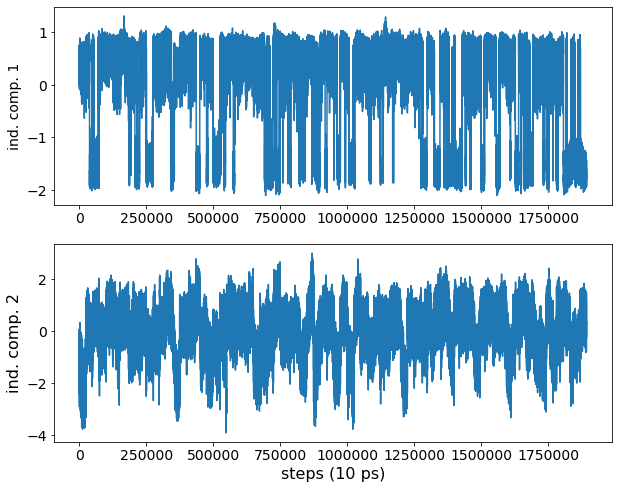

In [10]:
subplot2grid((2,1),(0,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
subplot2grid((2,1),(1,0))
plot(Y[:,1])
ylabel('ind. comp. 2')
xlabel('steps (10 ps)')
save_figure_H('TICA-Trajectories-1and2-1000ps-TICA-Bottleneck.png', label_size=16, tick_size=14)

In [11]:
n_clusters = 200
clustering = coor.cluster_kmeans(Y, k=n_clusters, max_iter=250, n_jobs=24, tolerance=1e-10, fixed_seed=True)

kmeans iterations:  37%|███▋      | 93/250 [11:43<05:10,  1.98s/it]   

09-07-25 15:08:41 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] INFO     Cluster centers converged after 95 steps.


100%|██████████| 250/250 [11:45<00:00,  1.39s/it]                  


In [12]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]

/home/farzin/mambaforge/envs/Pyemma/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


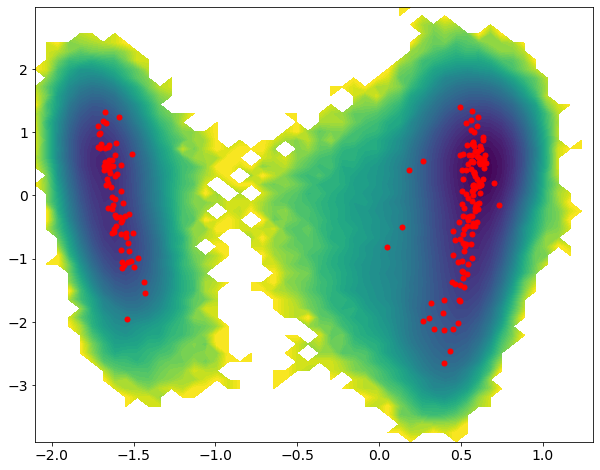

In [13]:
# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 50, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o', color ='r', markersize=5)
save_figure_H('Cluster-centers-1000ps-TICA-bottleneck-200Cluster.png', label_size=16, tick_size=14)

In [14]:
dtrajs = clustering.dtrajs  # get discrete trajectories

In [15]:
lags = [1,2,5,10,20,50,100, 150, 200, 250, 300, 400, 500, 600]
its = msm.its(dtrajs, lags=lags)

100%|██████████| 14/14 [00:05<00:00,  5.58it/s]                                 


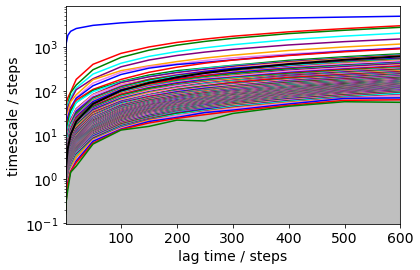

In [16]:
mplt.plot_implied_timescales(its)

100%|██████████| 14/14 [02:41<00:00, 12.64s/it]                        


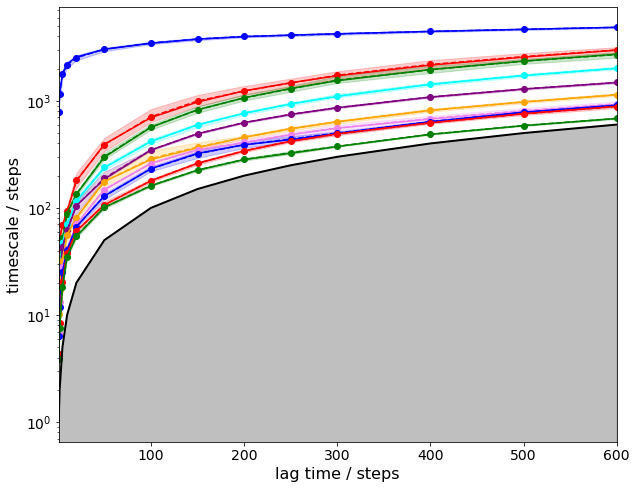

In [17]:
its = msm.its(dtrajs, lags=lags, errors='bayes', nits=10, nsamples=100)
mplt.plot_implied_timescales(its)
save_figure_H('BayesITS-MSM--1000ps-TICA-Bottleneck-200Cluster-2states.png', label_size=16, tick_size=14)

# MSM Estimation

In [18]:
M = msm.estimate_markov_model(dtrajs, 200) # 2ns


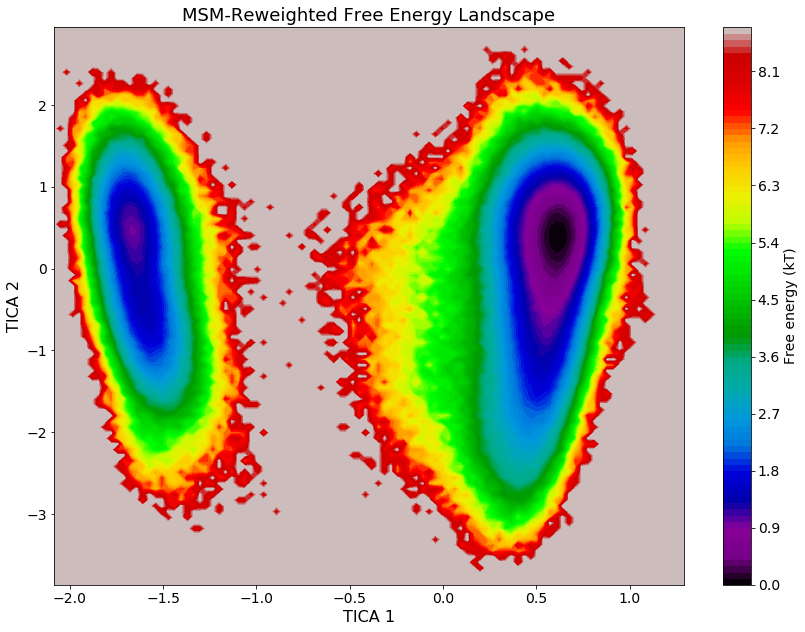

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pyemma.plots as mplt

# 1. Get MSM-reweighted trajectory weights
weights = np.concatenate(M.trajectory_weights())

# 2. Prepare TICA-projected coordinates
tica_proj = np.vstack(Y)  # assuming Y is list of [frames x TICs]

# 3. Plot reweighted free-energy landscape
fig = plt.figure(figsize=(12, 9))
mplt.plot_free_energy(tica_proj[:, 0], tica_proj[:, 1], weights=weights)
plt.xlabel('TICA 1', fontsize=16)
plt.ylabel('TICA 2', fontsize=16)
plt.title('MSM‑Reweighted Free Energy Landscape', fontsize=18)
plt.tight_layout()
plt.savefig('MSM-Reweighted-FEL.png', dpi=300)
plt.show()

# Validation - Chapman-Kolmogorov test

In [21]:
ckt = M.cktest(2)

100%|██████████| 9/9 [00:01<00:00,  7.77it/s]                                 


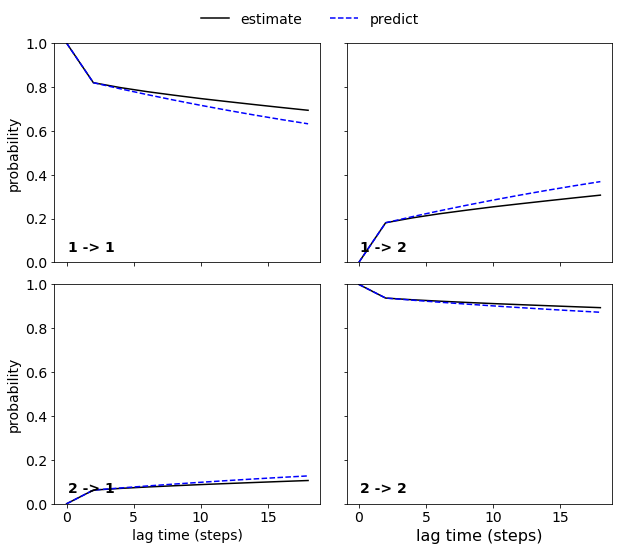

In [22]:
mplt.plot_cktest(ckt, dt=0.01, units='steps')
save_figure_H('transition probability-1000ps-TICA-bottleneck-200Cluster-2states.png', label_size=16, tick_size=14)

(-0.5, 10.5)

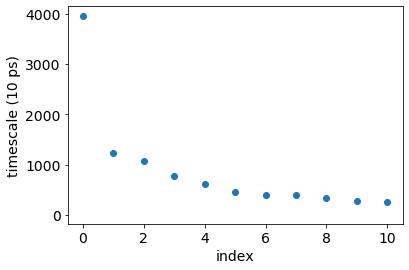

In [23]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ps)'); xlim(-0.5,10.5)
#save_figure_H('Implied time scales.png', label_size=16, tick_size=14)

In [24]:
# do pcca with 4 states now
pcca = M.pcca(2)
pcca_sets_2 = M.metastable_sets

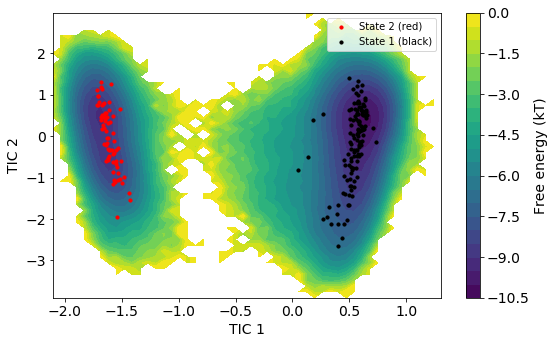

In [25]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import numpy as np

# Plot
plt.figure(figsize=(8, 5))

# Free energy contour plot
cf = plt.contourf(F.T, 20, extent=extent, cmap='viridis')  # increase contour levels for smoother shading
cbar = plt.colorbar(cf, label='Free energy (kT)')  # colorbar with label

# Macrostate coloring
cols = ['red', 'black']
labels = [ 'State 2 (red)', 'State 1 (black)']

# Plot macrostate-assigned microstates
size = 10
for i in range(2):
    plt.scatter(cc_x[pcca_sets_2[i]], cc_y[pcca_sets_2[i]], color=cols[i], s=size, label=labels[i])

# Axis labels
plt.xlabel('TIC 1', fontsize=14)
plt.ylabel('TIC 2', fontsize=14)

# Legend
plt.legend(loc='best', fontsize=10)

# Save & show
plt.tight_layout()
plt.savefig('PCCA-1000ps-TICA-bottleneck-200Cluster-2states-labeled.png', dpi=300)
plt.show()


In [26]:
import numpy as np

# Get coarse-grained transition matrix from PCCA
P_macro = pcca.coarse_grained_transition_matrix  # shape: (4, 4)

# Get MSM lag time
tau = M.lagtime

# Compute rate matrix (generator)
K_macro = (P_macro - np.eye(2)) / tau  # in 1/ps

# Convert to /ns
K_macro_ns = K_macro * 1000

# Labels based on your macrostate coloring
labels = ['Orange', 'Magenta', 'Red', 'Black']

# Print rates between all macrostate pairs
print("Transition rates between PCCA macrostates (/ns):\n")
for i in range(2):
    for j in range(2):
        if i != j:
            print(f"Rate ({labels[i]} → {labels[j]}): {K_macro_ns[i, j]:.2f} /ns")


Transition rates between PCCA macrostates (/ns):

Rate (Orange → Magenta): 0.18 /ns
Rate (Magenta → Orange): 0.06 /ns


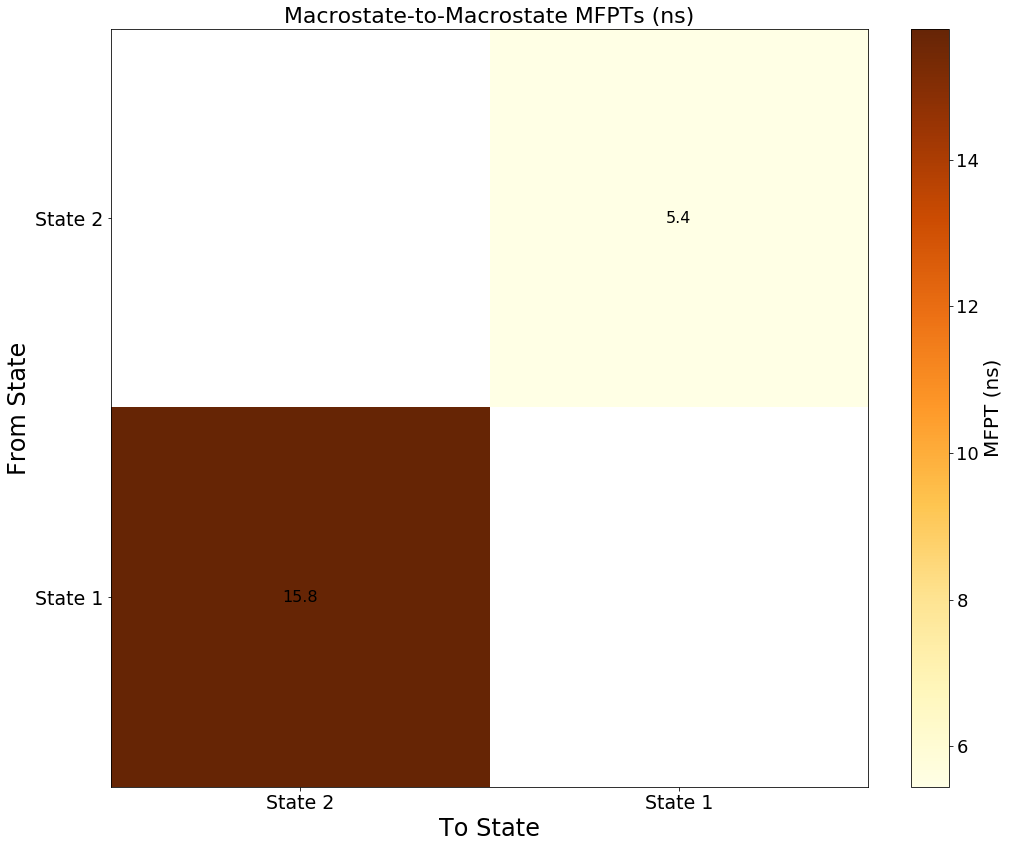

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Get rate matrix in 1/ns
P_macro = pcca.coarse_grained_transition_matrix
tau = M.lagtime
K_macro_ns = (P_macro - np.eye(2)) / tau * 1000  # units: 1/ns

# Compute MFPTs (1 / rate)
mfpt_matrix = np.full_like(K_macro_ns, np.nan)
for i in range(2):
    for j in range(2):
        if i != j and K_macro_ns[i, j] > 0:
            mfpt_matrix[i, j] = 1.0 / K_macro_ns[i, j]

# Labels
labels = ['State 2', 'State 1']

# Plot
fig, ax = plt.subplots(figsize=(16, 12))
cax = ax.imshow(mfpt_matrix, cmap='YlOrBr', interpolation='nearest')

# Colorbar (fixed sizing)
cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('MFPT (ns)', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Make colorbar tick labels larger


# Axis labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(labels, fontsize=19)
ax.set_yticklabels(labels, fontsize=19)
ax.set_xlabel('To State', fontsize=24)
ax.set_ylabel('From State', fontsize=24)
ax.set_title('Macrostate-to-Macrostate MFPTs (ns)', fontsize=22)

# Annotate each cell
for i in range(2):
    for j in range(2):
        if not np.isnan(mfpt_matrix[i, j]):
            ax.text(j, i, f'{mfpt_matrix[i, j]:.1f}', ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.savefig("macrostate_mfpt_heatmap_matplotlib-200cluster.png", dpi=300)
plt.show()



In [30]:
import numpy as np

# Get stationary distribution of microstates(500)
pi = M.stationary_distribution  # shape: (n_microstates,)

# Use all 4 macrostates
pcca_sets = pcca.metastable_sets
labels = ['Orange', 'Magenta', 'Red', 'Black']

# Compute and print population for each macrostate
print("Macrostate populations (fraction):\n")
for i, macro_indices in enumerate(pcca_sets):
    pop = np.sum(pi[macro_indices])
    print(f"{labels[i]} macrostate population: {pop:.4f}")


Macrostate populations (fraction):

Orange macrostate population: 0.2563
Magenta macrostate population: 0.7437


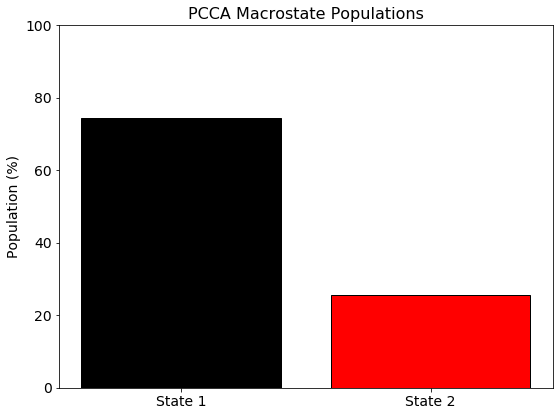

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Compute populations
pcca_sets = pcca.metastable_sets
pi = M.stationary_distribution

labels = ['State 2', 'State 1']
colors = ['red', 'black']
populations = [np.sum(pi[macro]) for macro in pcca_sets]

# Convert to percentage
populations_percent = [p * 100 for p in populations]

# Sort by descending population
sorted_data = sorted(zip(populations_percent, labels, colors), reverse=True)
populations_sorted, labels_sorted, colors_sorted = zip(*sorted_data)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(labels_sorted, populations_sorted, color=colors_sorted, edgecolor='k')

plt.ylabel('Population (%)', fontsize=14)
plt.title('PCCA Macrostate Populations', fontsize=16)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('pcca_macrostate_population_percent.png', dpi=300)
plt.show()
